# Customer Centric analysis of Sales Performance

### Objective:
The objective of this notebook is to analyse how the Sales Performance of a seller is related to the experience of their clients. In this case, the Sales Performance is whether a seller has an above average monthly income or not. 

### How:
The hypothesis is that the Sales Performance can be predicted by 4 features:
* The ratio of shipments within Deadline informed to the client
* The average star rating of the seller
* If the seller offers products that belong to top selling categories 
* The population density of the region in which the seller is located


# Data Understanding and preparation

The detailed description of the data under analysis can be accessed in the link below:

https://www.kaggle.com/olistbr/brazilian-ecommerce

In [1]:
#Importing libraries
import sys
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import math
import numpy as np
import random
import seaborn as sns

my_path_raw = '/Users/leonardoyamaguishi/Documents/Udacity/Data-Science/Project 1/data/raw/'
my_path_processed = '/Users/leonardoyamaguishi/Documents/Udacity/Data-Science/Project 1/data/'

In [2]:
#Reading the data

#Main Orders Dataset
olist_orders_dataset = pd.read_csv(my_path_raw + 'olist_orders_dataset.csv')

#Products that compose each order
olist_order_items_dataset = pd.read_csv(my_path_raw + 'olist_order_items_dataset.csv')

#Details from the Products, including seller_id
olist_products_dataset = pd.read_csv(my_path_raw + 'olist_products_dataset.csv')

#Details from the Sellers, including their geographic state
olist_sellers_dataset = pd.read_csv(my_path_raw + 'olist_sellers_dataset.csv')

#Reviews from orders
olist_order_reviews_dataset = pd.read_csv(my_path_raw + 'olist_order_reviews_dataset.csv')

#Revenue data
revenue_data = pd.read_csv(my_path_processed + 'revenue_per_seller.csv')

#Processed data for the model
modelling_df = pd.read_csv(my_path_processed + 'modelling_df.csv')

### Important Key Values for the proposed analysis:

In [3]:
#The order_ids are unique and not repeated in the olist_orders_dataset
list1 = olist_orders_dataset['order_id'].sort_values().to_list()
list2 = sorted(list(set(olist_orders_dataset['order_id'])))

list1 == list2
#As this is a table with single order_id values, it can be used as an order lookup table
#The key value would be the order_id with a one to many correspondence

True

In [4]:
#Function for date time handling
def time_converter(df, time_str_column):
    converted_time = []
    new_column_name = 'conv_' + time_str_column   
    
    for time in df[time_str_column]:
        converted_time.append(datetime.strptime(time, "%Y-%m-%d %H:%M:%S"))
        
    df = df.drop(time_str_column, axis = 1)
    df[new_column_name] = converted_time
    return df

### Revenue Data Analysis and Business Questions

In [5]:
revenue_data

,seller_id,total_revenue,first_sell_date,total_months,average_monthly_revenue,above_average
0,0015a82c2db000af6aaaf3ae2ecb0532,2685.00,2017-09-26 22:17:05,12,223.750000,False
1,001cca7ae9ae17fb1caed9dfb1094831,24487.03,2017-02-04 19:06:04,19,1288.791053,True
2,002100f778ceb8431b7a1020ff7ab48f,1216.60,2017-09-14 01:00:31,12,101.383333,False
3,003554e2dce176b5555353e4f3555ac8,120.00,2017-12-15 06:52:25,9,13.333333,False
4,004c9cd9d87a3c30c522c48c4fc07416,19435.74,2017-01-27 10:34:34,20,971.787000,True
...,...,...,...,...,...,...
2965,ffc470761de7d0232558ba5e786e57b7,1529.13,2018-02-20 18:47:21,7,218.447143,False
2966,ffdd9f82b9a447f6f8d4b91554cc7dd3,2101.20,2017-03-05 16:21:27,19,110.589474,False
2967,ffeee66ac5d5a62fe688b9d26f83f534,1839.86,2017-09-30 15:56:56,12,153.321667,False
2968,fffd5413c0700ac820c7069d66d98c89,8535.00,2017-07-24 21:13:55,14,609.642857,True


### Question 1: How is the average monthly revenue distributed between the sellers?
The distribution of average monthly revenue is skewed with a significantly high standard deviation.

In [6]:
revenue_data['average_monthly_revenue'].describe()

count     2970.000000
mean       400.249273
std        995.820686
min          0.361111
25%         33.991403
50%        124.751000
75%        356.586364
max      16764.649231
Name: average_monthly_revenue, dtype: float64

<AxesSubplot:xlabel='average_monthly_revenue', ylabel='Count'>

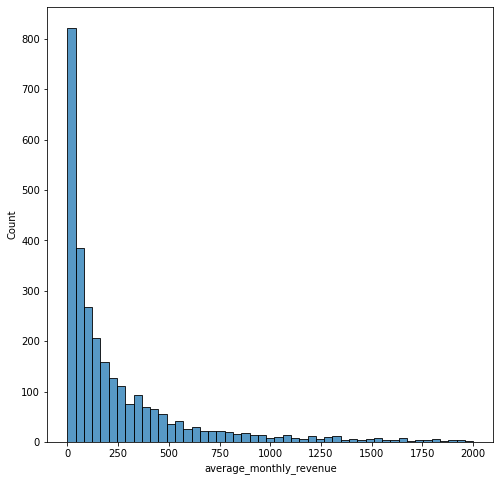

In [7]:
fig = plt.figure(figsize = (8,8))
sns.histplot(data = revenue_data['average_monthly_revenue'], binrange = (0, 2000))

### Question 2: Is the Average Monthly Revenue higher for older sellers?
No, as visualized in the Scatter Plot below and in the Spearman's correlation, this hypothesis isn't valid.

<AxesSubplot:xlabel='total_months', ylabel='average_monthly_revenue'>

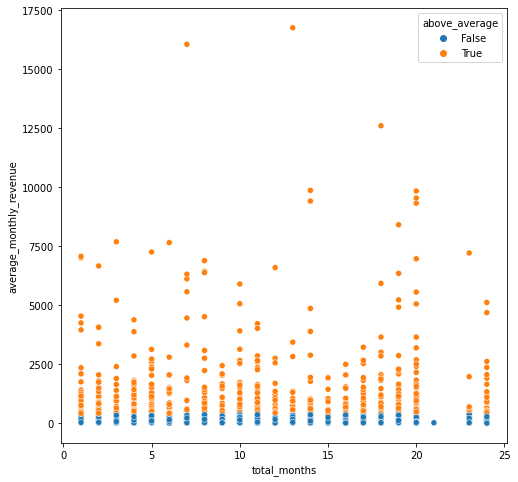

In [8]:
fig = plt.figure(figsize = (8,8))
sns.scatterplot(x = 'total_months', y = 'average_monthly_revenue', data = revenue_data, hue = 'above_average')
# revenue_data.plot.scatter(x = ['total_months'], y = ['average_monthly_revenue'])

In [9]:
revenue_data[['total_months', 'average_monthly_revenue']].corr(method = 'spearman')

,total_months,average_monthly_revenue
total_months,1.000000,-0.073016
average_monthly_revenue,-0.073016,1.000000


### Modelling DataFrame Analysis

In [10]:
modelling_df

,Unnamed: 0,seller_id,within_expected_delivery_date,review_score,offer_trending_category,state_population_density,above_average
0,0,0015a82c2db000af6aaaf3ae2ecb0532,1.000000,3.666667,0,166.25,False
1,1,001cca7ae9ae17fb1caed9dfb1094831,0.944444,3.935897,0,76.25,True
2,2,002100f778ceb8431b7a1020ff7ab48f,0.833333,4.037037,1,166.25,False
3,3,003554e2dce176b5555353e4f3555ac8,1.000000,5.000000,0,17.65,False
4,4,004c9cd9d87a3c30c522c48c4fc07416,0.922156,4.127976,1,166.25,True
...,...,...,...,...,...,...,...
2965,2965,ffc470761de7d0232558ba5e786e57b7,0.933333,4.300000,1,166.25,False
2966,2966,ffdd9f82b9a447f6f8d4b91554cc7dd3,1.000000,4.250000,1,52.40,False
2967,2967,ffeee66ac5d5a62fe688b9d26f83f534,0.857143,4.214286,0,166.25,False
2968,2968,fffd5413c0700ac820c7069d66d98c89,0.862069,3.931034,1,166.25,True


### Question 3: Is there a  correlation between delivering the products within the expected date and Average Monthly Revenue?
Probably, however this correlation wouldn't be strong. The Histogram below indicates that sellers that deliver their products within the expected date tend to have average monthly revenues above the average of the platform.

<AxesSubplot:xlabel='within_expected_delivery_date', ylabel='Count'>

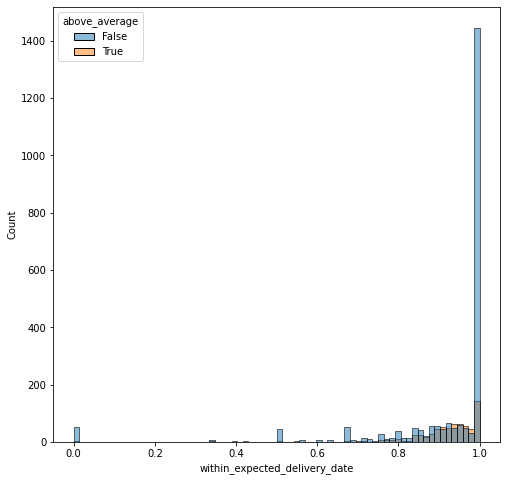

In [11]:
fig = plt.figure(figsize = (8,8))
sns.histplot(data = modelling_df, x = 'within_expected_delivery_date', hue = 'above_average', hue_order = [False, True])

### Question 4: Is there a correlation between Average Review Score and Average Monthly Revenue?
Yes, however this correlation also wouldn't be strong as indicated in the histogram below.

<AxesSubplot:xlabel='review_score', ylabel='Count'>

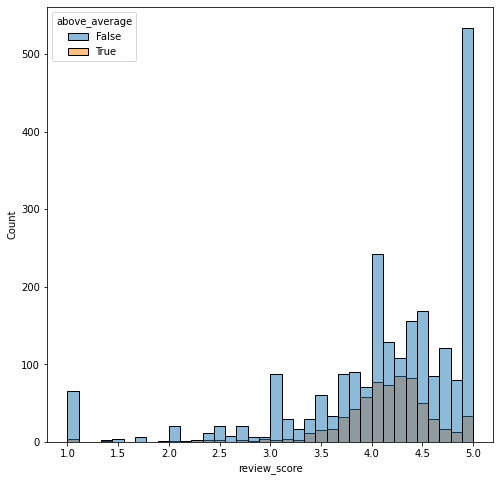

In [12]:
fig = plt.figure(figsize = (8,8))
sns.histplot(data = modelling_df, x = 'review_score', hue = 'above_average', hue_order = [False, True])

### Question 5: Does offering products from top selling categories result in higher Average Monthly Revenues?
As this metrics are correlated, yes. On the other hand, there are sellers with higher average monthly revenues that don't offer such products.

<AxesSubplot:xlabel='offer_trending_category', ylabel='Count'>

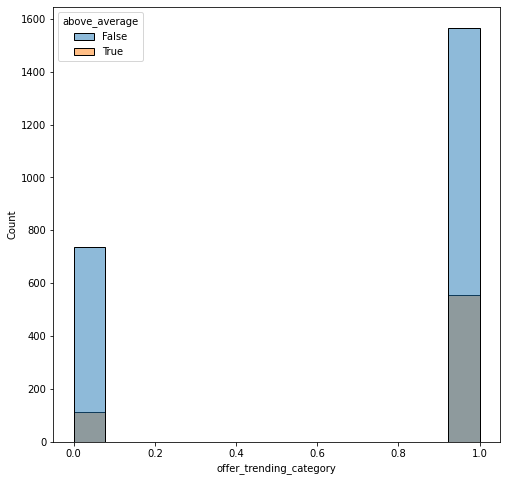

In [13]:
fig = plt.figure(figsize = (8,8))
sns.histplot(data = modelling_df, x = 'offer_trending_category', hue = 'above_average', hue_order = [False, True])

### Question 6: Do sellers in states with higher population densities have higher revenues?
Not necessarily, probably because this information isn't commonly considered by customers.

<AxesSubplot:xlabel='state_population_density', ylabel='Count'>

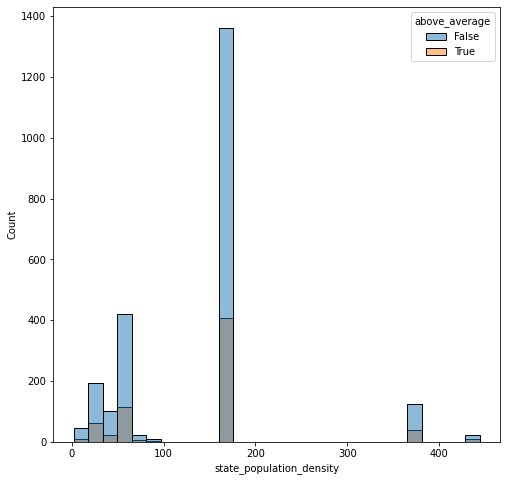

In [14]:
fig = plt.figure(figsize = (8,8))
sns.histplot(data = modelling_df, x = 'state_population_density', hue = 'above_average', hue_order = [False, True])

### Brief visualization of the comments:

In [15]:
comments = olist_order_reviews_dataset['review_comment_message'].dropna()
for comment in comments[0:100]:
    print(comment)

Recebi bem antes do prazo estipulado.
Parabéns lojas lannister adorei comprar pela Internet seguro e prático Parabéns a todos feliz Páscoa
aparelho eficiente. no site a marca do aparelho esta impresso como 3desinfector e ao chegar esta com outro nome...atualizar com a marca correta uma vez que é o mesmo aparelho
Mas um pouco ,travando...pelo valor ta Boa.

Vendedor confiável, produto ok e entrega antes do prazo.
GOSTARIA DE SABER O QUE HOUVE, SEMPRE RECEBI E ESSA COMPRA AGORA ME DECPCIONOU
Péssimo
Loja nota 10
obrigado pela atençao amim dispensada
A compra foi realizada facilmente.
A entrega foi efetuada muito antes do prazo dado.
O produto já começou a ser usado e até o presente,
sem problemas.
relógio muito bonito e barato.
Não gostei ! Comprei gato por lebre
Sempre compro pela Internet e a entrega ocorre antes do prazo combinado, que acredito ser o prazo máximo. No stark o prazo máximo já se esgotou e ainda não recebi o produto.
Recebi exatamente o que esperava. As demais encomendas